In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [4]:
"""
Open the training data.
"""
training_data_filepath = 'F:/ZaknafeinII_Backup_02-02-22/daea/training_data_generation/id16/output/mfcc_training_data_dict.pickle'

with open(training_data_filepath, 'rb') as f:
    data_dict = pickle.load(f)
    
for key in data_dict:
    print(key, 'is of shape', data_dict.get(key).shape)

train_input is of shape (180518, 64)
val_input is of shape (38683, 64)
test_input is of shape (38683, 64)
train_labels is of shape (180518, 64)
val_labels is of shape (38683, 64)
test_labels is of shape (38683, 64)


In [5]:
"""
Standardize/scale the data.
"""

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(np.concatenate((data_dict.get('train_input'),
                                   data_dict.get('val_input'),
                                   data_dict.get('test_input'),
                                   data_dict.get('train_labels'),
                                   data_dict.get('val_labels'),
                                   data_dict.get('test_labels'))))

overlap_train_scaled = min_max_scaler.transform(data_dict.get('train_input'))
overlap_val_scaled = min_max_scaler.transform(data_dict.get('val_input'))
overlap_test_scaled = min_max_scaler.transform(data_dict.get('test_input'))
character_train_scaled = min_max_scaler.transform(data_dict.get('train_labels'))
character_val_scaled = min_max_scaler.transform(data_dict.get('val_labels'))
character_test_scaled = min_max_scaler.transform(data_dict.get('test_labels'))

In [6]:
"""
Calculate the ideal masks such that (input vals)*(mask coefficients)=(label vals)
So --> (mask coefficients)=(label vals)/(input vals)
"""
# zero_count = 0
# minimum = -1
# for i in overlap_train_scaled:
#     for j in i:
#         if j == 0:
#             zero_count = zero_count + 1
#         if minimum == -1 and j != 0:
#             minimum = j
#         if j < minimum and j != 0:
#             minimum = j
# print(zero_count, minimum)

imask_train = np.divide(character_train_scaled, overlap_train_scaled)
imask_val = np.divide(character_val_scaled, overlap_val_scaled)
imask_test = np.divide(character_test_scaled, overlap_test_scaled)

C:\Users\ZAKNAF~1\AppData\Local\Temp/ipykernel_18660/438024550.py:17: RuntimeWarning: divide by zero encountered in true_divide
  imask_train = np.divide(character_train_scaled, overlap_train_scaled)
C:\Users\ZAKNAF~1\AppData\Local\Temp/ipykernel_18660/438024550.py:18: RuntimeWarning: divide by zero encountered in true_divide
  imask_val = np.divide(character_val_scaled, overlap_val_scaled)
C:\Users\ZAKNAF~1\AppData\Local\Temp/ipykernel_18660/438024550.py:19: RuntimeWarning: divide by zero encountered in true_divide
  imask_test = np.divide(character_test_scaled, overlap_test_scaled)
C:\Users\ZAKNAF~1\AppData\Local\Temp/ipykernel_18660/438024550.py:19: RuntimeWarning: invalid value encountered in true_divide
  imask_test = np.divide(character_test_scaled, overlap_test_scaled)


In [7]:
"""
Given overlap, predict imask.
"""

print('input shape:', overlap_train_scaled.shape)
print('input contains NaN values?:', np.any(np.isnan(overlap_train_scaled)))
print('input contains inf values?:', np.any(np.isinf(overlap_train_scaled)))
print('input datatype:', overlap_train_scaled.dtype)
overlap_train_scaled = overlap_train_scaled.astype('float32')
print('output shape:', imask_train.shape)
print('output contains NaN values?:', np.any(np.isnan(imask_train)))
print('output contains inf values?:', np.any(np.isinf(imask_train)))
imask_train[np.isinf(imask_train)] = 0
print('output contains inf values?:', np.any(np.isinf(imask_train)))


input shape: (180518, 64)
input contains NaN values?: False
input contains inf values?: False
input datatype: float32
output shape: (180518, 64)
output contains NaN values?: False
output contains inf values?: True
output contains inf values?: False


In [8]:
# """
# https://machinelearningmastery.com/multi-output-regression-models-with-python/
# """

# model_list = [LinearRegression(), KNeighborsRegressor(), DecisionTreeRegressor()]

# for model_type in model_list:
#     # define model
#     model = model_type
#     # fit model
#     model.fit(overlap_train_scaled, imask_train)

#     x = overlap_test_scaled[0]
#     y = imask_test[0]
#     yhat = model.predict([x])[0]

#     x_axis_list = list(range(0, len(x)))
#     plt.plot(x_axis_list, y)
#     plt.plot(x_axis_list, yhat)
#     plt.title(str(model_type))
#     plt.show()

In [9]:
"""
Prepare the training input and target output data
Using "target" with regression and "label" with classification is a a good idea
"""
train = np.concatenate((overlap_train_scaled, overlap_val_scaled))
target = np.concatenate((imask_train, imask_val))

print('train contains NaN values?:', np.any(np.isnan(train)))
print('train contains inf values?:', np.any(np.isinf(train)))
# print('input datatype:', overlap_train_scaled.dtype)
# overlap_train_scaled = overlap_train_scaled.astype('float32')
print('target shape:', target.shape)
print('target contains NaN values?:', np.any(np.isnan(target)))
print('target contains inf values?:', np.any(np.isinf(target)))
target[np.isinf(target)] = 0
print('target contains inf values?:', np.any(np.isinf(target)))

train contains NaN values?: False
train contains inf values?: False
target shape: (219201, 64)
target contains NaN values?: False
target contains inf values?: True
target contains inf values?: False


In [12]:
"""
Neural network time.
Basing work off of the following link:
https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33
https://towardsdatascience.com/how-to-build-a-neural-network-for-voice-classification-5e2810fe1efa
"""
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPooling1D


NN_model = Sequential()

# The Input Layer :
# expecting 64 input dimensions
NN_model.add(Dense(64, kernel_initializer='normal', input_dim = 64, activation='relu'))

# The Hidden Layers :
# NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
# NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
# NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))

# just a single 128 is our best looking graph so far
# NN_model.add(Dropout(0.1))
NN_model.add(Dense(128, activation = 'relu'))
# NN_model.add(Dropout(0.15))
NN_model.add(Dense(256, activation = 'relu'))
# NN_model.add(MaxPooling1D(pool_size=2, strides=2, padding='valid'))
NN_model.add(Dense(128, activation = 'relu'))
# NN_model.add(Dropout(0.25))

# The Output Layer :
# changing the output dimensions from 1 to 64
NN_model.add(Dense(64, kernel_initializer='normal', activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dense_8 (Dense)             (None, 256)               33024     
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
Total params: 86,656
Trainable params: 86,656
Non-trainable params: 0
_________________________________________________________________


In [13]:
"""
Only save the best form of the model throughout the training process.
https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33

Notes:
- look into pruning during training
- explore this link: https://towardsdatascience.com/how-to-build-a-neural-network-for-voice-classification-5e2810fe1efa
  - has dropout layers
  - has graph to show performance over time during training
  - has early stopping
  - has layers to study
- train with GPU somehow
- better data preprocessing
- From librosa concerning MFCC generation: "If multi-channel audio input y is provided, the MFCC calculation 
  will depend on the peak loudness (in decibels) across all channels. The result may differ from independent 
  MFCC calculation of each channel."
"""
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
# checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
# callbacks_list = [checkpoint]

# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

NN_model.fit(train, 
             target, 
             epochs=512, 
             batch_size=1024, 
             validation_split = 0.2, 
#              callbacks=callbacks_list, 
             shuffle=True
            )

Epoch 1/512
172/172 [==============================] - 7s 26ms/step - loss: 0.1846 - mean_absolute_error: 0.1846 - val_loss: 0.1089 - val_mean_absolute_error: 0.1089
Epoch 2/512
172/172 [==============================] - 4s 23ms/step - loss: 0.1096 - mean_absolute_error: 0.1096 - val_loss: 0.1076 - val_mean_absolute_error: 0.1076
Epoch 3/512
172/172 [==============================] - 5s 27ms/step - loss: 0.1066 - mean_absolute_error: 0.1066 - val_loss: 0.1054 - val_mean_absolute_error: 0.1054
Epoch 4/512
172/172 [==============================] - 4s 20ms/step - loss: 0.1046 - mean_absolute_error: 0.1046 - val_loss: 0.1053 - val_mean_absolute_error: 0.1053
Epoch 5/512
172/172 [==============================] - 4s 21ms/step - loss: 0.1030 - mean_absolute_error: 0.1030 - val_loss: 0.1047 - val_mean_absolute_error: 0.1047
Epoch 6/512
172/172 [==============================] - 4s 21ms/step - loss: 0.1017 - mean_absolute_error: 0.1017 - val_loss: 0.1027 - val_mean_absolute_error: 0.1027
Epoc

172/172 [==============================] - 4s 23ms/step - loss: 0.0893 - mean_absolute_error: 0.0893 - val_loss: 0.0952 - val_mean_absolute_error: 0.0952
Epoch 51/512
172/172 [==============================] - 3s 18ms/step - loss: 0.0891 - mean_absolute_error: 0.0891 - val_loss: 0.0947 - val_mean_absolute_error: 0.0947
Epoch 52/512
172/172 [==============================] - 3s 16ms/step - loss: 0.0891 - mean_absolute_error: 0.0891 - val_loss: 0.0946 - val_mean_absolute_error: 0.0946
Epoch 53/512
172/172 [==============================] - 4s 23ms/step - loss: 0.0891 - mean_absolute_error: 0.0891 - val_loss: 0.0945 - val_mean_absolute_error: 0.0945
Epoch 54/512
172/172 [==============================] - 4s 24ms/step - loss: 0.0889 - mean_absolute_error: 0.0889 - val_loss: 0.0954 - val_mean_absolute_error: 0.0954
Epoch 55/512
172/172 [==============================] - 4s 21ms/step - loss: 0.0887 - mean_absolute_error: 0.0887 - val_loss: 0.0950 - val_mean_absolute_error: 0.0950
Epoch 56/51

172/172 [==============================] - 4s 21ms/step - loss: 0.0863 - mean_absolute_error: 0.0863 - val_loss: 0.0929 - val_mean_absolute_error: 0.0929
Epoch 100/512
172/172 [==============================] - 3s 20ms/step - loss: 0.0863 - mean_absolute_error: 0.0863 - val_loss: 0.0937 - val_mean_absolute_error: 0.0937
Epoch 101/512
172/172 [==============================] - 4s 21ms/step - loss: 0.0861 - mean_absolute_error: 0.0861 - val_loss: 0.0929 - val_mean_absolute_error: 0.0929
Epoch 102/512
172/172 [==============================] - 4s 23ms/step - loss: 0.0861 - mean_absolute_error: 0.0861 - val_loss: 0.0946 - val_mean_absolute_error: 0.0946
Epoch 103/512
172/172 [==============================] - 3s 20ms/step - loss: 0.0861 - mean_absolute_error: 0.0861 - val_loss: 0.0927 - val_mean_absolute_error: 0.0927
Epoch 104/512
172/172 [==============================] - 5s 27ms/step - loss: 0.0860 - mean_absolute_error: 0.0860 - val_loss: 0.0934 - val_mean_absolute_error: 0.0934
Epoch 

Epoch 148/512
172/172 [==============================] - 4s 24ms/step - loss: 0.0849 - mean_absolute_error: 0.0849 - val_loss: 0.0918 - val_mean_absolute_error: 0.0918
Epoch 149/512
172/172 [==============================] - 4s 22ms/step - loss: 0.0848 - mean_absolute_error: 0.0848 - val_loss: 0.0925 - val_mean_absolute_error: 0.0925
Epoch 150/512
172/172 [==============================] - 4s 21ms/step - loss: 0.0848 - mean_absolute_error: 0.0848 - val_loss: 0.0927 - val_mean_absolute_error: 0.0927
Epoch 151/512
172/172 [==============================] - 3s 18ms/step - loss: 0.0847 - mean_absolute_error: 0.0847 - val_loss: 0.0928 - val_mean_absolute_error: 0.0928
Epoch 152/512
172/172 [==============================] - 4s 21ms/step - loss: 0.0850 - mean_absolute_error: 0.0850 - val_loss: 0.0919 - val_mean_absolute_error: 0.0919
Epoch 153/512
172/172 [==============================] - 5s 28ms/step - loss: 0.0847 - mean_absolute_error: 0.0847 - val_loss: 0.0913 - val_mean_absolute_error:

Epoch 197/512
172/172 [==============================] - 4s 24ms/step - loss: 0.0839 - mean_absolute_error: 0.0839 - val_loss: 0.0937 - val_mean_absolute_error: 0.0937
Epoch 198/512
172/172 [==============================] - 4s 21ms/step - loss: 0.0839 - mean_absolute_error: 0.0839 - val_loss: 0.0918 - val_mean_absolute_error: 0.0918
Epoch 199/512
172/172 [==============================] - 3s 19ms/step - loss: 0.0839 - mean_absolute_error: 0.0839 - val_loss: 0.0926 - val_mean_absolute_error: 0.0926
Epoch 200/512
172/172 [==============================] - 5s 26ms/step - loss: 0.0838 - mean_absolute_error: 0.0838 - val_loss: 0.0914 - val_mean_absolute_error: 0.0914
Epoch 201/512
172/172 [==============================] - 4s 22ms/step - loss: 0.0839 - mean_absolute_error: 0.0839 - val_loss: 0.0915 - val_mean_absolute_error: 0.0915
Epoch 202/512
172/172 [==============================] - 4s 23ms/step - loss: 0.0838 - mean_absolute_error: 0.0838 - val_loss: 0.0913 - val_mean_absolute_error:

Epoch 246/512
172/172 [==============================] - 3s 19ms/step - loss: 0.0830 - mean_absolute_error: 0.0830 - val_loss: 0.0909 - val_mean_absolute_error: 0.0909
Epoch 247/512
172/172 [==============================] - 5s 32ms/step - loss: 0.0831 - mean_absolute_error: 0.0831 - val_loss: 0.0921 - val_mean_absolute_error: 0.0921
Epoch 248/512
172/172 [==============================] - 4s 24ms/step - loss: 0.0831 - mean_absolute_error: 0.0831 - val_loss: 0.0914 - val_mean_absolute_error: 0.0914
Epoch 249/512
172/172 [==============================] - 3s 19ms/step - loss: 0.0832 - mean_absolute_error: 0.0832 - val_loss: 0.0910 - val_mean_absolute_error: 0.0910
Epoch 250/512
172/172 [==============================] - 4s 21ms/step - loss: 0.0832 - mean_absolute_error: 0.0832 - val_loss: 0.0915 - val_mean_absolute_error: 0.0915
Epoch 251/512
172/172 [==============================] - 4s 22ms/step - loss: 0.0831 - mean_absolute_error: 0.0831 - val_loss: 0.0918 - val_mean_absolute_error:

Epoch 295/512
172/172 [==============================] - 5s 26ms/step - loss: 0.0825 - mean_absolute_error: 0.0825 - val_loss: 0.0922 - val_mean_absolute_error: 0.0922
Epoch 296/512
172/172 [==============================] - 4s 22ms/step - loss: 0.0825 - mean_absolute_error: 0.0825 - val_loss: 0.0918 - val_mean_absolute_error: 0.0918
Epoch 297/512
172/172 [==============================] - 5s 28ms/step - loss: 0.0826 - mean_absolute_error: 0.0826 - val_loss: 0.0916 - val_mean_absolute_error: 0.0916
Epoch 298/512
172/172 [==============================] - 4s 22ms/step - loss: 0.0825 - mean_absolute_error: 0.0825 - val_loss: 0.0909 - val_mean_absolute_error: 0.0909
Epoch 299/512
172/172 [==============================] - 5s 26ms/step - loss: 0.0825 - mean_absolute_error: 0.0825 - val_loss: 0.0914 - val_mean_absolute_error: 0.0914
Epoch 300/512
172/172 [==============================] - 3s 20ms/step - loss: 0.0825 - mean_absolute_error: 0.0825 - val_loss: 0.0917 - val_mean_absolute_error:

Epoch 344/512
172/172 [==============================] - 4s 21ms/step - loss: 0.0821 - mean_absolute_error: 0.0821 - val_loss: 0.0905 - val_mean_absolute_error: 0.0905
Epoch 345/512
172/172 [==============================] - 4s 25ms/step - loss: 0.0821 - mean_absolute_error: 0.0821 - val_loss: 0.0914 - val_mean_absolute_error: 0.0914
Epoch 346/512
172/172 [==============================] - 4s 25ms/step - loss: 0.0820 - mean_absolute_error: 0.0820 - val_loss: 0.0924 - val_mean_absolute_error: 0.0924
Epoch 347/512
172/172 [==============================] - 3s 19ms/step - loss: 0.0821 - mean_absolute_error: 0.0821 - val_loss: 0.0934 - val_mean_absolute_error: 0.0934
Epoch 348/512
172/172 [==============================] - 4s 21ms/step - loss: 0.0820 - mean_absolute_error: 0.0820 - val_loss: 0.0914 - val_mean_absolute_error: 0.0914
Epoch 349/512
172/172 [==============================] - 4s 22ms/step - loss: 0.0820 - mean_absolute_error: 0.0820 - val_loss: 0.0913 - val_mean_absolute_error:

Epoch 393/512
172/172 [==============================] - 4s 21ms/step - loss: 0.0817 - mean_absolute_error: 0.0817 - val_loss: 0.0909 - val_mean_absolute_error: 0.0909
Epoch 394/512
172/172 [==============================] - 4s 21ms/step - loss: 0.0817 - mean_absolute_error: 0.0817 - val_loss: 0.0902 - val_mean_absolute_error: 0.0902
Epoch 395/512
172/172 [==============================] - 3s 18ms/step - loss: 0.0817 - mean_absolute_error: 0.0817 - val_loss: 0.0925 - val_mean_absolute_error: 0.0925
Epoch 396/512
172/172 [==============================] - 4s 23ms/step - loss: 0.0816 - mean_absolute_error: 0.0816 - val_loss: 0.0919 - val_mean_absolute_error: 0.0919
Epoch 397/512
172/172 [==============================] - 5s 29ms/step - loss: 0.0816 - mean_absolute_error: 0.0816 - val_loss: 0.0914 - val_mean_absolute_error: 0.0914
Epoch 398/512
172/172 [==============================] - 4s 24ms/step - loss: 0.0816 - mean_absolute_error: 0.0816 - val_loss: 0.0918 - val_mean_absolute_error:

Epoch 442/512
172/172 [==============================] - 4s 25ms/step - loss: 0.0813 - mean_absolute_error: 0.0813 - val_loss: 0.0913 - val_mean_absolute_error: 0.0913
Epoch 443/512
172/172 [==============================] - 4s 24ms/step - loss: 0.0814 - mean_absolute_error: 0.0814 - val_loss: 0.0918 - val_mean_absolute_error: 0.0918
Epoch 444/512
172/172 [==============================] - 3s 15ms/step - loss: 0.0813 - mean_absolute_error: 0.0813 - val_loss: 0.0907 - val_mean_absolute_error: 0.0907
Epoch 445/512
172/172 [==============================] - 3s 17ms/step - loss: 0.0813 - mean_absolute_error: 0.0813 - val_loss: 0.0905 - val_mean_absolute_error: 0.0905
Epoch 446/512
172/172 [==============================] - 4s 21ms/step - loss: 0.0813 - mean_absolute_error: 0.0813 - val_loss: 0.0915 - val_mean_absolute_error: 0.0915
Epoch 447/512
172/172 [==============================] - 4s 23ms/step - loss: 0.0813 - mean_absolute_error: 0.0813 - val_loss: 0.0910 - val_mean_absolute_error:

Epoch 491/512
172/172 [==============================] - 5s 27ms/step - loss: 0.0810 - mean_absolute_error: 0.0810 - val_loss: 0.0912 - val_mean_absolute_error: 0.0912
Epoch 492/512
172/172 [==============================] - 4s 20ms/step - loss: 0.0810 - mean_absolute_error: 0.0810 - val_loss: 0.0913 - val_mean_absolute_error: 0.0913
Epoch 493/512
172/172 [==============================] - 3s 19ms/step - loss: 0.0810 - mean_absolute_error: 0.0810 - val_loss: 0.0910 - val_mean_absolute_error: 0.0910
Epoch 494/512
172/172 [==============================] - 4s 21ms/step - loss: 0.0810 - mean_absolute_error: 0.0810 - val_loss: 0.0905 - val_mean_absolute_error: 0.0905
Epoch 495/512
172/172 [==============================] - 4s 22ms/step - loss: 0.0810 - mean_absolute_error: 0.0810 - val_loss: 0.0912 - val_mean_absolute_error: 0.0912
Epoch 496/512
172/172 [==============================] - 4s 24ms/step - loss: 0.0810 - mean_absolute_error: 0.0810 - val_loss: 0.0913 - val_mean_absolute_error:

(180518, 64)
(64,)
(64,)


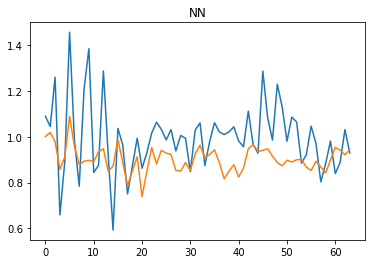

In [14]:
print(overlap_train_scaled.shape)
print(overlap_test_scaled[0].shape)
print(imask_test[0].shape)


x = overlap_test_scaled[0].reshape((1, 64))
y = imask_test[0]
yhat = NN_model.predict(x)

x_axis_list = list(range(0, 64))
plt.plot(x_axis_list, y)
plt.plot(x_axis_list, yhat[0])
plt.title(str("NN"))
plt.show()

In [15]:
import IPython.display as ipd
import librosa
import librosa.display

reconstructed = overlap_test_scaled[0].reshape((1, 64)) * yhat

print('target contains NaN values?:', np.any(np.isnan(reconstructed)))
print('target contains inf values?:', np.any(np.isinf(reconstructed)))

reconstructed = min_max_scaler.inverse_transform(reconstructed)

print('target contains NaN values?:', np.any(np.isnan(reconstructed)))
print('target contains inf values?:', np.any(np.isinf(reconstructed)))

reconstructed = librosa.feature.inverse.mfcc_to_audio(reconstructed) 

ipd.Audio(reconstructed, rate=22050)

target contains NaN values?: False
target contains inf values?: False
target contains NaN values?: False
target contains inf values?: False
